<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/Elliot%20M/IntegratedGradientsImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


TO DO THIS, GO ON KAGGLE :https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri

THEN DOWLOAD TO ZIP USINNG THE DOWLOAD BUTTON.

THEN ADD IT TO YOUR GOOGLE DRIVE AS A ZIP FILE.
THEN MYDIRVE/YOUR_NOTEBOOK/DATASET.ZIP


In [4]:
!unzip "/content/drive/MyDrive/DST/archive.zip" -d "/content/data"



Archive:  /content/drive/MyDrive/DST/archive.zip
  inflating: /content/data/Testing/glioma_tumor/image(1).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(10).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(100).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(11).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(12).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(13).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(14).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(15).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(16).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(17).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(18).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(19).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(2).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(20).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(21

In [5]:
!ls /content/data


Testing  Training


Loaded image: /content/data/Training/pituitary_tumor/p (30).jpg


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

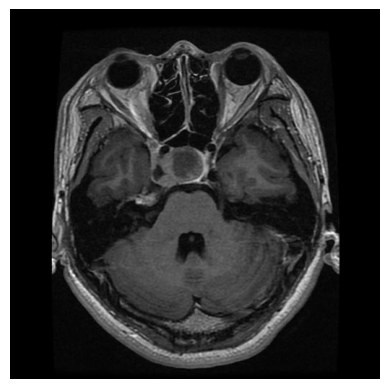

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

root = "/content/data/Training"

# Find the first image in the training folder
image_path = None
for subdir, dirs, files in os.walk(root):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(subdir, file)
            break
    if image_path:
        break

print("Loaded image:", image_path)

img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)

        # 224 → 112 → 56 after pooling twice
        self.fc1 = nn.Linear(32 * 56 * 56, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))   # (32, 56, 56)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

train_dataset = datasets.ImageFolder("/content/data/Training", transform=transform)
test_dataset  = datasets.ImageFolder("/content/data/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
import torch.optim as optim
import os, time, json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_val_acc = 0
checkpoint_path = "best_smallcnn.pth"

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

EPOCHS = 10   # fast training

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # ------- VALIDATION -------
    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(test_loader)
    val_acc = val_correct / val_total

    # Track
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

    # Save based on accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved best model → {checkpoint_path}")


Epoch [1/10] | Train Acc: 0.571 | Val Acc: 0.409
Saved best model → best_smallcnn.pth
Epoch [2/10] | Train Acc: 0.816 | Val Acc: 0.591
Saved best model → best_smallcnn.pth
Epoch [3/10] | Train Acc: 0.902 | Val Acc: 0.701
Saved best model → best_smallcnn.pth
Epoch [4/10] | Train Acc: 0.955 | Val Acc: 0.726
Saved best model → best_smallcnn.pth
Epoch [5/10] | Train Acc: 0.976 | Val Acc: 0.721
Epoch [6/10] | Train Acc: 0.988 | Val Acc: 0.718
Epoch [7/10] | Train Acc: 0.997 | Val Acc: 0.741
Saved best model → best_smallcnn.pth
Epoch [8/10] | Train Acc: 1.000 | Val Acc: 0.746
Saved best model → best_smallcnn.pth
Epoch [9/10] | Train Acc: 1.000 | Val Acc: 0.746
Epoch [10/10] | Train Acc: 1.000 | Val Acc: 0.746


In [11]:
model = SmallCNN(num_classes=4)
model.load_state_dict(torch.load("best_smallcnn.pth"))
model.to(device)
model.eval()


SmallCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [12]:

def integrated_gradients(model, x, baseline=None, m_steps=50):
    """
    Compute Integrated Gradients for an input x.
    model: pytorch model
    x: input image tensor of shape (1, C, H, W)
    baseline: same shape as x
    m_steps: number of steps in the Riemann approximation
    """

    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(x)

    # interpolate between baseline and x
    alphas = torch.linspace(0, 1, m_steps).reshape(-1, 1, 1, 1).to(x.device)
    interpolated = baseline + alphas * (x - baseline)

    # store gradients
    gradients = []

    for i in range(m_steps):
        interpolated_i = interpolated[i].unsqueeze(0).requires_grad_(True)
        output = model(interpolated_i)
        target = output.max(1)[0]  # predicted class score

        model.zero_grad()
        target.backward()

        gradients.append(interpolated_i.grad.detach())

    # approximate integral
    avg_gradients = torch.mean(torch.stack(gradients), dim=0)

    # IG formula
    ig = (x - baseline) * avg_gradients
    return ig


In [13]:

def smooth_integrated_gradients(
    model, x, baseline=None, m_steps=50, n_samples=25, noise_sigma=0.1
):
    """
    Compute Smooth Integrated Gradients.
    Averaging IG over noise-perturbed copies of input x.
    """

    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(x)

    all_igs = []

    for _ in range(n_samples):
        noise = torch.normal(mean=0, std=noise_sigma, size=x.shape).to(x.device)
        x_noisy = x + noise
        ig = integrated_gradients(model, x_noisy, baseline, m_steps)
        all_igs.append(ig)

    return torch.mean(torch.stack(all_igs), dim=0)


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def to_heatmap(attributions):
    """
    Convert attributions (1, C, H, W) → (H, W) heatmap.
    We sum over channels (for RGB) or just squeeze (for grayscale).
    """
    attributions = attributions.squeeze().cpu().numpy()

    # if 3 channels, sum like IG paper
    if attributions.ndim == 3:
        attributions = np.sum(attributions, axis=0)

    # normalise to [0,1]
    attributions = np.maximum(attributions, 0)
    attributions = attributions / (attributions.max() + 1e-9)

    return attributions

def show_heatmap(original, heatmap, title="Heatmap"):
    """
    original: image tensor (1, C, H, W)
    heatmap: (H, W)
    """
    img = original.squeeze().cpu().numpy()

    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))

    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap="gray")
    plt.imshow(heatmap, cmap="inferno", alpha=0.55)
    plt.title(title)
    plt.axis("off")
    plt.show()


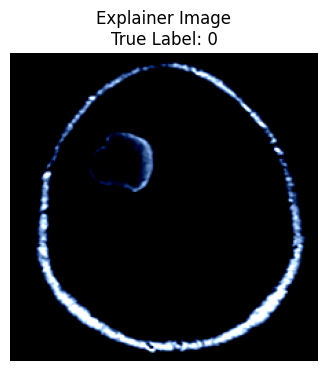

In [30]:
explainer_image, explainer_label = next(iter(test_loader))
explainer_image = explainer_image[2]        # take first image in batch
explainer_label = explainer_label[2].item()

explainer_image_device = explainer_image.unsqueeze(0).to(device)


plt.figure(figsize=(4,4))
plt.imshow(explainer_image.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Explainer Image\nTrue Label: {explainer_label}")
plt.show()

In [31]:
print(explainer_image_device.shape)
print(torch.min(explainer_image_device), torch.max(explainer_image_device))


torch.Size([1, 3, 224, 224])
tensor(-2.1179, device='cuda:0') tensor(2.0997, device='cuda:0')


In order to do IG, we need to first denormalize the explainer image.

In [32]:
def denormalize(x, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(x.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(x.device)
    return x * std + mean


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

explainer_image_denorm = denormalize(explainer_image_device, mean, std)



In [33]:
print(explainer_image_denorm.min(), explainer_image_denorm.max())


tensor(0., device='cuda:0') tensor(0.8784, device='cuda:0')


In [34]:
baseline = torch.zeros_like(explainer_image_denorm)

ig = integrated_gradients(
    model=model,
    x=explainer_image_denorm,
    baseline=baseline,
    m_steps=50
)

sg_ig = smooth_integrated_gradients(
    model=model,
    x=explainer_image_denorm,
    baseline=baseline,
    m_steps=50,
    n_samples=20,
    noise_sigma=0.1
)


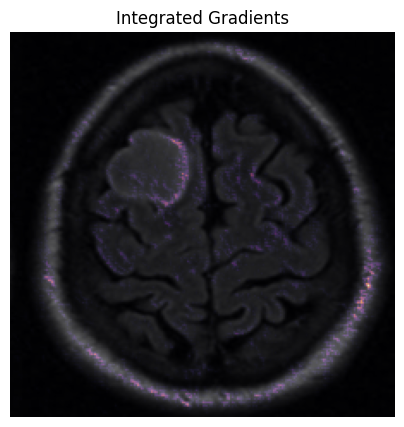

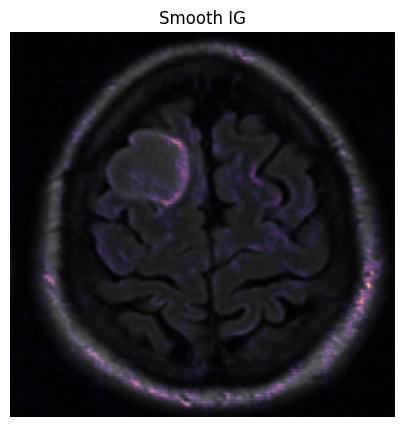

In [35]:
show_heatmap(explainer_image_denorm, to_heatmap(ig), "Integrated Gradients")
show_heatmap(explainer_image_denorm, to_heatmap(sg_ig), "Smooth IG")
